In [46]:
import scipy
import numpy
import math
import itertools
import functools
import seaborn as sns

In [47]:
numpy.set_printoptions(suppress=True)

#Trabajo práctico

## Demostración de sparse matrix (para propósitos de referencia)

In [48]:
scipy.sparse.csr_array((1, 13)).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [49]:
sparse = scipy.sparse.csr_array([1,2,3,0,0,0,4])
sparse_2 = scipy.sparse.csr_array([1,2,3,0,0,0,4])

In [50]:
print(sparse)

  (0, 0)	1
  (0, 1)	2
  (0, 2)	3
  (0, 6)	4


In [51]:
sparse_3 = scipy.sparse.lil_array((2,4))

In [52]:
sparse_3

<2x4 sparse array of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [53]:
sparse_3[1,1] = 1

# Parte 1: Generar A y b para NxN nodos

A es una matriz N^2 x N^2, correspondiente a la grilla con N^2 nodos.

Buscamos resolver Ax = b, donde x es la temperatura de los nodos.

## Funciones auxiliares

estas funciones definen el layout de los nodos. i representa el eje horizontal de izq a derecha, j el eje vertical de abajo hacia arriba

In [54]:
@functools.lru_cache
def all_nodes(N):
  ret = list(itertools.product(range(1, N+1), range(1, N+1)))
  return ret

@functools.lru_cache
def coordinate_to_node_number(grid_rowsize,i,j):
  """
  Determines how we number a node in the 2D position (i,j).
  i,j from 1 to grid_rowsize.
  Result from 1 to grid_rowsize squared.
  """
  return (i-1)*grid_rowsize + (j-1) + 1


# Devuelve la temperatura en las posiciones vacías en el extremo norte, sur, este, oeste
def edge_temperature(N, i,j, cardinal_temperatures):
  if(i == 0): return cardinal_temperatures['WEST']
  if(i == N + 1): return cardinal_temperatures['EAST']
  if(j == 0): return cardinal_temperatures['SOUTH']
  if(j == N + 1): return cardinal_temperatures['NORTH']


In [55]:
assert(coordinate_to_node_number(3,i=1,j=1) == 1)

In [56]:
assert(coordinate_to_node_number(3,i=1,j=3) == 3)

In [57]:
assert(coordinate_to_node_number(3,i=3,j=3) == 9)

In [58]:
assert(all_nodes(N=3)[0]== (1,1))

coordinate_to_node_number nos numera los nodos dependiendo de su posición en la grilla, del 1 al N^2.

is_there_a_node_in nos dice si hay un nodo en la posición i,j, en caso contrario se asume que es un nodo que existe en el extremo norte, sur, este, oeste (pues nunca se usan las posiciones noreste, suroeste, etc)

nearby_coordinates nos da 4 puntos que son adyacentes vertical u horizontalmente a un punto i,j, sin tomar en cuenta el tamaño de la grilla.

In [59]:


def is_there_a_node_in(N,i,j):
  return (i in range(1,N+1)) and (j in range(1,N+1))

# returns an array with the [up, down, left, right] points of i,j
def nearby_coordinates(i, j):
  return [[i,j+1], [i, j-1], [i-1, j], [i+1, j]]

::neighbor_nodes toma coordenadas y nos dice si tiene nodos o no.

In [60]:
# returns all neighbor nodes that exist in the range 1 <= i,j <= 3, as a map object
# If they don't exist in the range, don't return them!
def _neighbor_nodes(N,neighbor_points):
  return filter(lambda pair: is_there_a_node_in(N,*pair), neighbor_points)
# generate row ij based on the nodes we found
# TODO: refactor, skip 0 values
def _generate_cell_value(current_column, base_node, neighbors):
  # The cell aij of the current node is always 4
  if(current_column == base_node):
    return 4;
  elif(current_column in neighbors):
    return -1;
  return 0;

## El algoritmo principal!

Este algoritmo genera la fila de A correspondiente a la ecuación Eij.
Llamamos akl, a la entrada de a correspondiente a la fila k y columna l.
Generamos la fila sabiendo que la entrada diagonal akk debe ser 4, y las entradas correspondientes a los nodos adyacentes al nodo ij son -1.

In [61]:
def generate_matrix_row(N, i, j, target_matrix):
  """
  N = 4
  M = (N - 1) * (N - 1) = 9 nodos
  A es una matrix 9x9


  A is a MxM matrix.
  We're trying to generate a row corresponding to the the node m = coordinate_to_node_number(i,j),
  which corresponds to the equation Eij,
  1 <= i,j <= M
  1 <= m <= MxM

  Where the equation Eij is:
  T[i,j] = T[(i+1),j] + T[(i-1),j] + T[i,j+1] + T[j-1]

  And edge values (existing in a row or column <1 or >3) are predefined constants.
  """
  M = N*N
  current_node = coordinate_to_node_number(N,i,j) # corresponde al numero de fila

  # the 4 points surrounding i,j in a grid (up, down, left, right)
  nearby = nearby_coordinates(i,j)

  #  valid node neighbors
  neighbors = _neighbor_nodes(N, nearby)

  # number them from 1 to M
  neighbors = map(lambda pair: coordinate_to_node_number(N, pair[0], pair[1]), neighbors)
  neighbors = list(neighbors)

  for cell in range(1, M+1):
    target_matrix[current_node-1,cell-1] = _generate_cell_value(cell, current_node, neighbors)

  return target_matrix


Pudiendo generar las filas de A, podemos generar todo A:

In [62]:
# Generate matrix
# N es la altura de la grilla, o sea N=3 implica 9 nodos en una grilla y A es dimension 9x9
# TODO: hacer mas eficiente, crear A de una vez
def generate_matrix(N):
  target_matrix = scipy.sparse.lil_array((N**2, N**2))
  for (i,j) in all_nodes(N):
    target_matrix = generate_matrix_row(N, i, j, target_matrix)
  return target_matrix

Conociendo las temperatures norte, sur, este, oeste, podemos generar b
(sabemos que es la suma de las temperaturas de los extremos a los que el nodo es adyacente)

In [63]:


# if the node is adjacent to an edge, get the temperatures at the edge
def edge_temperatures(N, i, j, cardinal_temperatures):
  # toma los 4 vecinos, y toma los que NO son nodos (o sea estan en la esquina)
  edges = filter(lambda pair: not is_there_a_node_in(N, *pair), nearby_coordinates(i,j))
  # ve si sus temperaturas son NW, NS, etc.
  return map(lambda pair: edge_temperature(N, *pair, cardinal_temperatures), edges)

def generate_b_entry(N, i, j, cardinal_temperatures):
  # this is the b value corresponding to the (i,j)th equation
  return sum(edge_temperatures(N, i,j, cardinal_temperatures))

def generate_b(N, cardinal_temperatures):
  return [generate_b_entry(N, i, j, cardinal_temperatures) for (i,j) in all_nodes(N)]

## Ejemplos
N = 4, M = 9, A is a 9x9 matrix
it has exactly 2 valid node neighbors

In [64]:
test_matrix = generate_matrix(3)

In [65]:
print(test_matrix.toarray())

[[ 4. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  4.]]


In [66]:
CARDINAL_TEMPS = {'NORTH': 0.,'SOUTH': 0., 'EAST': 0., 'WEST': 0.}
generate_b(3, CARDINAL_TEMPS)

[0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0]

# PARTE 2: Algoritmo SOR

Implementa la fórmula derivada del sistema matricial A = D + L + U (Wikipedia en inglés) con la tecnica de reemplazo progresivo de Gauss-Sordel (?).

Para usar, debo reemplazar la funcion A[i,j] con algo que devuelva valores aii de una matriz cuadrada a, y la función b(index) con algo que me devuelva valores de un vector b, para solucionar Ax=b.

_x_iterations es una lista de k elementos, cada elemento representa una iteración x(k) que es un vector de n entradas, y la voy rellenando en secuencia, reutilizando valores.

## Datos de entrada de solve for x

El algoritmo para generar las entradas de x(k) fue derivado de la formulación matricial, y se ve así:

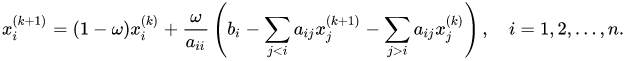

In [67]:
from numpy.lib.index_tricks import IndexExpression

def a_times_x_j_k(A, i,j,x):
    return A[i,j] * x[0, j]

def x_i(b,A, index, previous_iteration, curr_iteration, omega, n):
  # sumando 1
  sum1 = (1 - omega)* previous_iteration[0, index]

  # sumando 2
    # factor
  factor = omega / A[index,index]

  # sumatorias
  current_iteration_sum = 0
  elems =  A[[index], :].nonzero()
  for j in [j for j in elems[1] if j < index]:
    current_iteration_sum += a_times_x_j_k(A, index, j, curr_iteration)

  # sumatorias
  old_iteration_sum = 0
  for j in [j for j in elems[1] if j > index]:
    old_iteration_sum += a_times_x_j_k(A, index, j, previous_iteration)

    # bi
  bi = b[index]

    # factor (bi - sumatorias)
  sum2 = factor * (bi - current_iteration_sum - old_iteration_sum)

  return sum1 + sum2

Calcula un vector x dados los calculos anteriores. En el calculo de xi, utiliza las entradas xj, j < i ya calculadas.

In [68]:
def x(b, A, previous_iteration, curr_iteration, omega, n):
  # we need to initialize this in order to use our results
  # from this same iteration
  for index in range(0,n):
    curr_iteration[0,index] = x_i(b, A, index, previous_iteration, curr_iteration, omega, n)

  return curr_iteration

Corre las iteraciones del vector x, guardándolas en un a lista de _x_iterations

In [69]:

# PRINCIPAL
def solve_for_x_until(b, A,  seed, until=1, omega=1.5):
  assert(until > 0)
  n = len(b)
  assert(len(seed) == n)

  # crea matriz de 2 filas
  previous_iteration = numpy.array(seed, ndmin=2)
  curr_iteration = numpy.empty((1, n))

  error = math.inf
  iterations=[]
  error_log = []
  while error > until:
    curr_iteration = x(b, A, previous_iteration, curr_iteration, omega, n)
    # intercambiar columnas
    iterations.append((curr_iteration - previous_iteration))
    # error
    ssq_difference = numpy.sum(((curr_iteration - previous_iteration)[0]**2))
    ssq_current_iteration = numpy.sum((curr_iteration)[0]**2)
    error = ssq_difference / ssq_current_iteration
    error_log.append(error)

    previous_iteration = numpy.copy(curr_iteration)

  return (curr_iteration, iterations, error_log)


# Tests

In [70]:
CARDINAL_TEMPS_2 = {'NORTH': 100.,'SOUTH': -100., 'EAST': 100., 'WEST': -100.}
GRID = 31
_b = generate_b(N=GRID, cardinal_temperatures=CARDINAL_TEMPS_2)
_A = generate_matrix(N=GRID) # must be an array of arrays nxn

In [71]:
(_x, iterations, errors) = solve_for_x_until(_b, _A, seed = [1]* (GRID**2), until=0.01, omega=1.5)

In [72]:
errors

[1.0181963426940048,
 0.12530477210243185,
 0.04315955585956537,
 0.019470405591805802,
 0.010532988460412595,
 0.006454791885305585]

<Axes: >

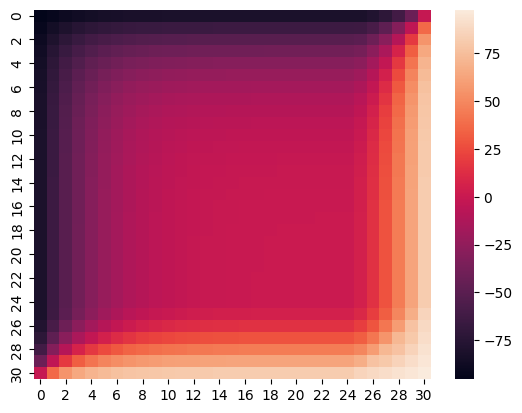

In [73]:
reshaped = numpy.reshape(_x, (GRID, GRID))
sns.heatmap(reshaped)

In [74]:
import json

In [75]:
import seaborn as sns

# N = 4

In [76]:
CARDINAL_TEMPS_2 = {'NORTH': 1.,'SOUTH': 1., 'EAST': 1., 'WEST': 1.}
GRID = 3
_b = generate_b(N=GRID, cardinal_temperatures=CARDINAL_TEMPS_2)
_A = generate_matrix(N=GRID) # must be an array of arrays nxn

iterations_needed = []
for _omega in numpy.arange(1,2,0.05):
 (_x, iterations, errors) = solve_for_x_until(_b, _A, seed = [0]* (GRID**2), until=0.01, omega=_omega)
 iterations_needed.append({"OMEGA": _omega, "ITERATIONS":len(iterations), "ERRORS": errors})

In [77]:
iterations_needed

[{'OMEGA': 1.0,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.11858558320025171,
   0.028525084367650867,
   0.007640723573057503]},
 {'OMEGA': 1.05,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.11303272420495704,
   0.025337031053655194,
   0.006053007653359389]},
 {'OMEGA': 1.1,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.10784264459784157,
   0.022368733016265272,
   0.004652347424897425]},
 {'OMEGA': 1.1500000000000001,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.10315528664547169,
   0.019715426100256873,
   0.003473094868046225]},
 {'OMEGA': 1.2000000000000002,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.09915244667294705,
   0.01750077576183169,
   0.0025637918824527686]},
 {'OMEGA': 1.2500000000000002,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.09606740914798859,
   0.01588631952404651,
   0.0019981168097932818]},
 {'OMEGA': 1.3000000000000003,
  'ITERATIONS': 4,
  'ERRORS': [1.0,
   0.09419653580458699,
   0.01508492948131394,
   0.0018922297912206765]},
 {'OMEGA': 1.3500000000000003,
  'IT

# N = 32

In [78]:
CARDINAL_TEMPS_2 = {'NORTH': 1.,'SOUTH': 1., 'EAST': 1., 'WEST': 1.}
GRID = 31
_b = generate_b(N=GRID, cardinal_temperatures=CARDINAL_TEMPS_2)
_A = generate_matrix(N=GRID) # must be an array of arrays nxn

In [79]:
iterations_needed = []
for _omega in numpy.arange(1,2,0.05):
 (_x, iterations, errors) = solve_for_x_until(_b, _A, seed = [0]* (GRID**2), until=0.0001, omega=_omega)
 iterations_needed.append({"OMEGA": _omega, "ITERATIONS":len(iterations), "ERRORS": errors})

In [80]:
iterations_needed

[{'OMEGA': 1.0,
  'ITERATIONS': 44,
  'ERRORS': [1.0,
   0.12978828165378178,
   0.04292655675037578,
   0.020494628669286016,
   0.011809696286917125,
   0.007617560962199083,
   0.0052955662075047675,
   0.0038827495286664444,
   0.0029624210844667693,
   0.0023310241218211986,
   0.0018798619523009658,
   0.0015467377260864527,
   0.0012940386739045686,
   0.0010979655590469782,
   0.0009428800563671195,
   0.0008181723295879876,
   0.0007164438230998201,
   0.000632410967863627,
   0.0005622210357403806,
   0.0005030123841184833,
   0.0004526243281061887,
   0.0004094012500493187,
   0.0003720575749065885,
   0.0003395829552700458,
   0.0003111745661032571,
   0.00028618801707031244,
   0.00026410126652516455,
   0.000244487755116053,
   0.00022699616920941556,
   0.00021133503340980123,
   0.0001972608623549175,
   0.0001845689646433033,
   0.00017308624302759474,
   0.00016266551138965053,
   0.0001531809743387691,
   0.0001445246053311716,
   0.00013660322460500807,
   0.0001293

<Axes: >

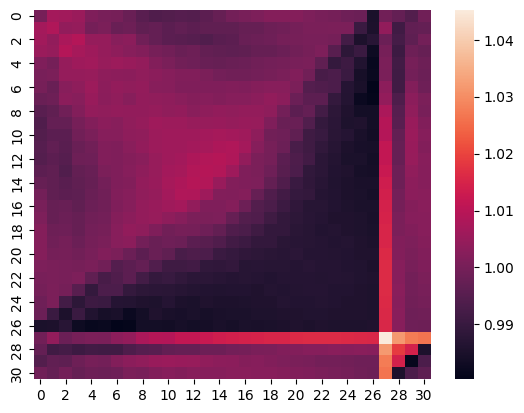

In [81]:
reshaped = numpy.reshape(_x, (GRID, GRID))
sns.heatmap(reshaped)

# Parte II

In [82]:
CARDINAL_TEMPS_2 = {'NORTH': 40.,'SOUTH': 20., 'EAST': 90., 'WEST': 20.}
GRID = 7
_b = generate_b(N=GRID, cardinal_temperatures=CARDINAL_TEMPS_2)
_A = generate_matrix(N=GRID) # must be an array of arrays nxn

In [83]:
(_x, iterations, errors) = solve_for_x_until(_b, _A, seed = [0]* (GRID**2), until=0.001, omega=_omega)

<Axes: >

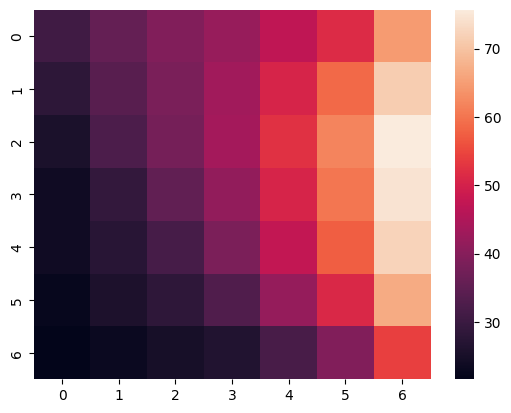

In [84]:
reshaped = numpy.reshape(_x, (GRID, GRID))
sns.heatmap(numpy.flip(reshaped.transpose(), axis=0))

# Repetir parte 1 con N=4, N=32 y menor tolerancia

In [85]:
CARDINAL_TEMPS_2 = {'NORTH': 1.,'SOUTH': 1., 'EAST': 1., 'WEST': 1.}
GRID = 31
_b = generate_b(N=GRID, cardinal_temperatures=CARDINAL_TEMPS_2)
_A = generate_matrix(N=GRID) # must be an array of arrays nxn

In [86]:
iterations_needed = []
for _omega in numpy.arange(1,2,0.05):
 (_x, iterations, errors) = solve_for_x_until(_b, _A, seed = [0]* (GRID**2), until=0.000000001, omega=_omega)
 iterations_needed.append({"OMEGA": _omega, "ITERATIONS":len(iterations), "ERRORS": errors})